# Paths and Directories

In [1]:
import os, shutil
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import mlconfig
from importlib import import_module

def load_function(attr):
    module_, func = attr.rsplit('.', maxsplit=1)
    return getattr(import_module(module_), func)

################ CONFIG FILE #################

config = mlconfig.load('./config_resnet18.yaml')

##############################################

config.set_immutable()

PATH = config.dataset.path
train_path = config.dataset.train_path

if not os.path.exists(config.dataset.path):
    os.mkdir(config.dataset.path)

if not os.path.exists(config.dataset.train_path):
    os.mkdir(config.dataset.train_path)

if not os.path.exists(config.dataset.test_path):
    os.mkdir(config.dataset.test_path)

if os.path.exists(os.path.join(PATH, 'Rice_Citation_Request.txt')):
    os.remove(os.path.join(PATH, 'Rice_Citation_Request.txt'))

classes = os.listdir(train_path)
"""
In case you are running this code for the first time, 'train' will be empty.
The parent dataset folder will contain 5+2 folders with 5 class folders, train and test. So parse the parent directory.
"""
if len(classes) == 0:
    classes = os.listdir(PATH)
    classes.remove('train')
    classes.remove('test')
    classes.remove('Rice_Citation_Request.txt')
num_classes = len(classes)

print(f"Number of classes : {num_classes}\nClasses : {classes}")

Number of classes : 5
Classes : ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']


# Organizing Data into Train & Test

In [3]:
split = config.dataset.train_split

if len(os.listdir(train_path))==0:
    train_size = int(len(os.listdir(os.path.join(PATH, classes[0])))*split)

    for i in range(num_classes) :
        os.mkdir(os.path.join(config.dataset.train_path, classes[i]))
        os.mkdir(os.path.join(config.dataset.test_path, classes[i]))

        all_images = os.listdir(os.path.join(PATH, classes[i]))
        for img in all_images[:train_size]:
            shutil.move(os.path.join(PATH, classes[i], img), os.path.join(config.dataset.train_path, classes[i], img))
        for img in all_images[train_size:]:
            shutil.move(os.path.join(PATH, classes[i], img), os.path.join(config.dataset.test_path, classes[i], img))
        
        if len(os.listdir(os.path.join(PATH, classes[i])))==0:
            os.rmdir(os.path.join(PATH, classes[i]))

train_size = 0
test_size = 0
for i in classes :
    train_size += len(os.listdir(os.path.join(config.dataset.train_path, i)))
    test_size += len(os.listdir(os.path.join(config.dataset.test_path, i)))

print(f"Total Training samples = {train_size}\nTotal Validation/Test samples = {test_size}")

Total Training samples = 60000
Total Validation/Test samples = 15000


# Data Visualization

Image shape : (250, 250, 3)


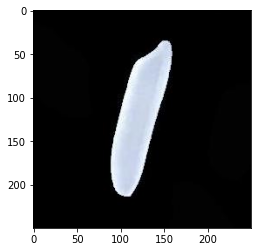

In [4]:
all_basmati = os.listdir(os.path.join(config.dataset.train_path, 'Basmati'))
img = np.asarray(Image.open(os.path.join(config.dataset.train_path, 'Basmati', all_basmati[0])))

plt.imshow(img)

print(f"Image shape : {img.shape}")

Rice Row 1 : Arborio
Rice Row 2 : Basmati
Rice Row 3 : Ipsala
Rice Row 4 : Jasmine
Rice Row 5 : Karacadag


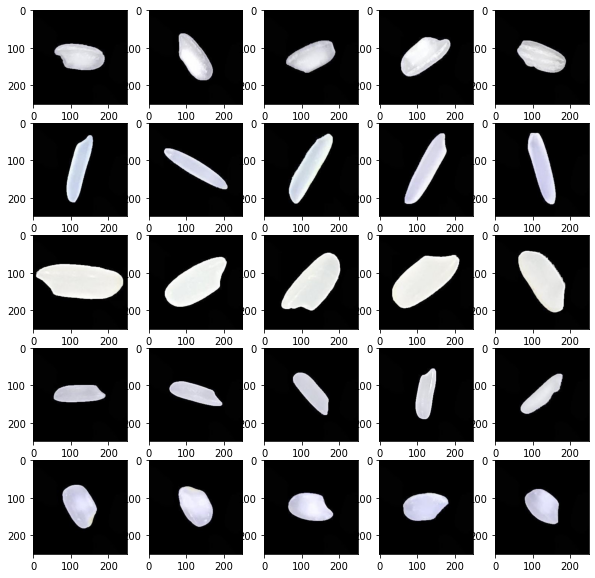

In [5]:
samples = []

if not os.path.exists(config.dataset.train_path):
    for i in classes :
        images = os.listdir(os.path.join(PATH, i))
        for j in images[:5]:
            samples.append(np.asarray(Image.open(os.path.join(PATH, i, j))))
else:
    for i in classes :
        images = os.listdir(os.path.join(config.dataset.train_path, i))
        for j in images[:5]:
            samples.append(np.asarray(Image.open(os.path.join(config.dataset.train_path, i, j))))

fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
idx = 0
for i in range(num_classes):
    print(f'Rice Row {i+1} : {classes[i]}')
    for j in range(5):        
        axes[i, j].imshow(samples[idx])
        idx+=1


# CNN Classifier : ResNet-18

## Libraries & Paths

In [6]:
import torch, torchvision
from torch.utils.data.dataloader import DataLoader

PATH = config.dataset.path

## Preparing DataLoaders

In [7]:
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train = torchvision.datasets.ImageFolder(config.dataset.train_path, transform=transform)
val = torchvision.datasets.ImageFolder(config.dataset.test_path, transform=transform)

batch_size = config.dataset.batch_size
train_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
val_dl = DataLoader(val, batch_size=batch_size)

train = None
val = None

print(f"Number of Train batches : {len(train_dl)}\nNumber of Test batches : {len(val_dl)}")

Number of Train batches : 938
Number of Test batches : 235


## Prediction using Pre-trained ResNet-18

In [8]:
model = load_function(config.model.architecture)(pretrained=config.model.pretrained)
model.fc = torch.nn.Linear(in_features=512, out_features=num_classes, bias=True)

In [9]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

In [10]:
# Execution time : 5m 26.9s

total = 0
correct = 0
with torch.no_grad():
    for (img, label) in train_dl:
        img, label = img.to(device), label.to(device)
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        torch.cuda.empty_cache()
print(f"Accuracy on Train set : {(correct/total)*100}")

Accuracy on Train set : 17.805


In [11]:
# Execution time : 1m 20.4s

total = 0
correct = 0
with torch.no_grad():
    for (img, label) in val_dl:
        img, label = img.to(device), label.to(device)
        output = model(img)
        _, predicted = torch.max(output.data, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()
        torch.cuda.empty_cache()
print(f"Accuracy on Validation/Test set : {(correct/total)*100}")

Accuracy on Validation/Test set : 19.793333333333333


## Training ResNet-18 from scratch

In [12]:
torch.cuda.empty_cache()
model = load_function(config.model.architecture)(pretrained=False)
model.fc = torch.nn.Linear(in_features=512, out_features=num_classes, bias=True)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

import numpy as np
import copy, timeit

optimizer = load_function(config.optimizer.name)(model.parameters(), lr=config.optimizer.lr)
xent = load_function(config.loss_function.name)()
scheduler = load_function(config.scheduler.name)(optimizer, step_size=config.scheduler.step_size, gamma=config.scheduler.gamma)

if device!='cpu':
    model = model.to(device)

val_loss = []
val_acc = []
train_loss = []
train_acc = []
epochs = 20

best_acc = 0
best_model = copy.deepcopy(model.state_dict())

start = timeit.default_timer()
for epoch in range(1, epochs+1):
    print(f"Epoch : {epoch}\n")
    dataloader = None
    
    for phase in ['train', 'val']:
        loss = 0
        correct = 0
        total = 0
        batch_num = 0
        
        if phase == 'train' :
            model.train()
            dataloader = train_dl
        else:
            model.eval()
            dataloader = val_dl

        for (img, label) in dataloader:
            img, label = img.to(device), label.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                output = model(img)
                _, pred = torch.max(output.data, 1)
                loss = xent(output, label)
                if phase=='train' :
                    loss.backward()
                    optimizer.step()
            
            loss += loss.item() * img.size(0)
            torch.cuda.empty_cache()
            correct += torch.sum(pred == label.data)
            total += label.size(0)
            batch_num += 1
            if batch_num % 50 == 0:
                print(f"Epoch : {epoch}\t{phase} batch {batch_num} completed")
        
        if phase=='train' :
            train_loss.append(loss/len(train_dl))
            train_acc.append(correct/total)
            scheduler.step()
            print(f'{phase} Loss: {train_loss[-1]:.4f}\tAccuracy: {train_acc[-1]:.4f}')
        else :
            val_loss.append(loss/len(val_dl))
            val_acc.append(correct/total)
            print(f'{phase} Loss: {val_loss[-1]:.4f}\tAccuracy: {val_acc[-1]:.4f}')

            if val_acc[-1] > best_acc :
                best_acc = val_acc[-1]
                best_model = copy.deepcopy(model.state_dict())

        torch.cuda.empty_cache()
    
    print()

end = timeit.default_timer()
print(f"Total time elapsed = {end - start} seconds")
name = f'rice_pytorch_{epoch}_{best_acc:.5f}.pth'
model.load_state_dict(best_model)
model = model.to('cpu')
torch.save(model.state_dict(), name)

Epoch : 1

Epoch : 1	train batch 50 completed
Epoch : 1	train batch 100 completed
Epoch : 1	train batch 150 completed
Epoch : 1	train batch 200 completed
Epoch : 1	train batch 250 completed
Epoch : 1	train batch 300 completed
Epoch : 1	train batch 350 completed
Epoch : 1	train batch 400 completed
Epoch : 1	train batch 450 completed
Epoch : 1	train batch 500 completed
Epoch : 1	train batch 550 completed
Epoch : 1	train batch 600 completed
Epoch : 1	train batch 650 completed
Epoch : 1	train batch 700 completed
Epoch : 1	train batch 750 completed
Epoch : 1	train batch 800 completed
Epoch : 1	train batch 850 completed
Epoch : 1	train batch 900 completed
train Loss: 0.0005	Accuracy: 0.9739
Epoch : 1	val batch 50 completed
Epoch : 1	val batch 100 completed
Epoch : 1	val batch 150 completed
Epoch : 1	val batch 200 completed
val Loss: 0.0361	Accuracy: 0.5735

Epoch : 2

Epoch : 2	train batch 50 completed
Epoch : 2	train batch 100 completed
Epoch : 2	train batch 150 completed
Epoch : 2	train ba

## Plotting Accuracy & Loss

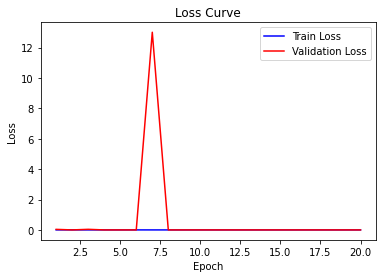

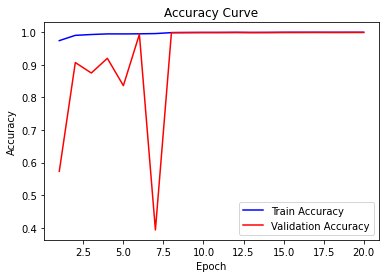

In [14]:
train_loss = [i.item() for i in train_loss]
val_loss = [i.item() for i in val_loss]
train_acc = [i.item() for i in train_acc]
val_acc = [i.item() for i in val_acc]

import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1,epochs+1), train_loss, color='blue')
plt.plot(range(1,epochs+1), val_loss, color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend(['Train Loss', 'Validation Loss'])
plt.show()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1,epochs+1), train_acc, color='blue')
plt.plot(range(1,epochs+1), val_acc, color='red')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend(['Train Accuracy', 'Validation Accuracy'])
plt.show()